In [ ]:
!pip install -Uq peft
!pip install -Uq transformers
!pip install -Uq datasets

In [ ]:
from transformers.image_utils import load_image
from transformers import AutoImageProcessor, AutoModelForImageClassification
import torch
import matplotlib.pyplot as plt
from peft import PeftConfig, PeftModel
from datasets import load_dataset

In [ ]:
repo_name = "ariG23498/vit_base_patch16_224.augreg2_in21k_ft_in1k.lora_ft_food101"
config = PeftConfig.from_pretrained(repo_name)

train_ds = load_dataset("food101", split="train[:10000]")

labels = train_ds.features["label"].names
num_labels = len(labels)
print(f"Number of labels: {num_labels}")

# Build the dictionaries for easier query
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[i] = label

model = AutoModelForImageClassification.from_pretrained(
    config.base_model_name_or_path,
    label2id=label2id,
    num_labels=num_labels,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)
# Load the Lora model
inference_model = PeftModel.from_pretrained(model, repo_name)

Number of labels: 101


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of TimmWrapperForImageClassification were not initialized from the model checkpoint at timm/vit_base_patch16_224.augreg2_in21k_ft_in1k and are newly initialized because the shapes did not match:
- head.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([101]) in the model instantiated
- head.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([101, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


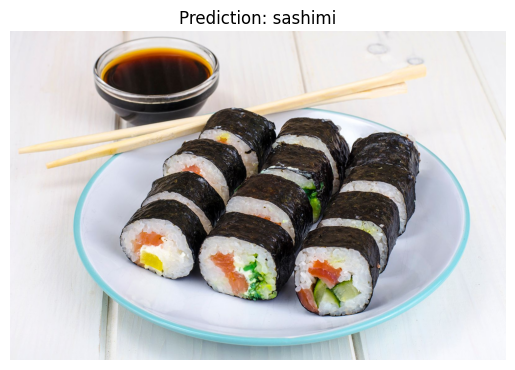

In [ ]:
image = load_image("https://cdn.britannica.com/52/128652-050-14AD19CA/Maki-zushi.jpg")
image_processor = AutoImageProcessor.from_pretrained(config.base_model_name_or_path)
inputs = image_processor(image, return_tensors="pt")

with torch.no_grad():
    logits = inference_model(**inputs).logits
    labels = logits.argmax(-1).item()

plt.imshow(image)
plt.axis("off")
plt.title(f"Prediction: {model.config.id2label[labels]}")
plt.show()